# Guided Project: Predicting House Sale Prices

This project is to apply into practice the intuition for model based learning, linear regression model, and further methods about data cleaning, transformation and feature selection.

The [data set](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) we explore is about the housings from 2006 to 2010 in Ames, Iowa, USA. It columns' descriptions can be read [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## 1. Introduction

We open the initial data set file with a tab as delimiter `AmesHousing.tsv` and create the training and testing data set (`train` and `test` respectively).

We then define three pipeline functions `transform_features()`, `select_features()` and `train_and_test()` in order to efficiently iterate on different models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

housing = pd.read_csv("AmesHousing.tsv", delimiter = "\t")
housing_rows_num = len(housing)
print("Total rows of the initial data set: " + str(housing_rows_num))

Total rows of the initial data set: 2930


We then set the default implementations for the three helper functions.

We will also write a copy of these functions' codes that can be updated in liberty at the end of this project. This way, when the Notebook kernel is run, the functions will be automatically updated according to these particular implementations.

In [2]:
# First function
def transform_features(df):
    return df

In [3]:
# Second function
def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

In [4]:
# Third function
def train_and_test(data):
    lr = LinearRegression()
    df = select_features(data) # containing feature cols and target col
    train = df[:len(df)//2]
    test = df[len(df)//2:]
    df_features = df.drop(columns = "SalePrice")
    lr.fit(df_features, df["SalePrice"])
    c_1 = lr.coef_
    c_0 = lr.intercept_
    prediction = lr.predict(test[df_features.columns])
    rmse = np.sqrt(mean_squared_error(prediction, test["SalePrice"]))
    print("Linear regression coefficients")
    print("c_1, c_0: " + str(c_1) + ", " + str(c_0))
    print("RMSE: " + str(rmse))
    return rmse

When we run the training-testing function, we get:

In [5]:
rmse = train_and_test(housing)

Linear regression coefficients
c_1, c_0: [111.69400086], 13289.63436475952
RMSE: 56948.148737954136


## 2. Data Cleaning

### First

Now we will update the `transform_features()` function. The function is intended to:
* remove features that we don't want to use in the model, based on merely the number of missing values or data leakage
* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
* create new features by combining other features

The `transform_features()` should not modify the `df` data frame, but copy it instead. Now `df` can be reused for other experimentations.

We select only columns with less than $5\%$ missing values. After left with these columns, we delete any rows having at least one missing value. By simple programming, there are only 53 such rows (less than $5\%$ of the total rows of 1465. An alternative way to do this would be to fill the missing values with their column means (using `fillna()` function in Pandas).

We then create two new columns from the existing features which do not contribute well to housing prices, as well as removing their component features. A column that reveals about the sales price such as `Misc Val` is alsdo removed, which is the price of miscellaneous house features.

In [6]:
def transform_features(df):
    # Copy df data
    df_cp = df.copy()
    
    # Select columns with less than 5% missing vals
    na_limit = 5/100 * len(df_cp)
    na_counts = df_cp.isna().sum()
    df_cp = df_cp.loc[:, na_counts < na_limit]
    # Delete all other rows with missing values
    df_cp.dropna(inplace = True)
    
    # Create new columns for linear regression
    df_cp["years_until_remod"] = df_cp["Year Remod/Add"] - df_cp["Year Built"]
    df_cp["years_until_sold"] = df_cp["Yr Sold"] - df_cp["Year Built"]
    
    # Remove columns that are just unuseful
    df_cp.drop(columns = ["Order", "PID",
                         "Year Built", "Year Remod/Add", "Yr Sold"], inplace = True)
    # Remove columns that leak data about final sales
    df_cp.drop(columns = ["Misc Val"], inplace = True)
    
    return df_cp

train = housing[:len(housing)//2]
transformed_train = transform_features(train)

### Second

We edit the `select_features()` to visualize the column correlations with `heatmap` from Seaborn, then eliminate one out of each pair that has a high absolute value of correlation, since putting similar-performing or opposite-performing columns creates unnecessary data overload.

We also save four features with the highest correlations with `SalePrice`.

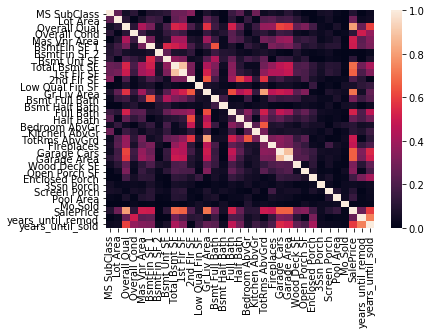

In [7]:
import seaborn as sns

def select_features(df):
    df = transform_features(df)
    # TRY: check numeric columns with high correlations
    corr_matrix = df.corr().abs()
    sns.heatmap(corr_matrix, xticklabels = True, yticklabels = True)
    plt.show()
    return df

selected_train = select_features(train)

Ignoring the target column `SalePrice`'s line, we can see that the variable pairs with highest correlation are (`Total Bsmt SF`, `1st Flr SF`), (`Garage Cars`, `Garage Area`), and (`Gr Liv Area`, `TotRms AbvGrd`). We should remove one of the variables in each pair.

From [the data set description](https://s3.amazonaws.com/dq-content/307/data_description.txt), `Total Bsmt SF` reflects the total area of the basement while `1st Flr SF` reflects the total area of the first floor. It turns out from the code below, `1st Flr SF` is generally of larger value than `Total Bsmt SF`. The variable with larger value may better capture the entire house lot area.

Meanwhile, `Garage Area` provides more flexibility as linear model feature compared to `Garage Cars`, since it has continuous values as opposed to `Garage Cars`'s discrete integer values. Similarly, we pick `Gr Liv Area` over `TotRms AbvGrd`.

We henceforth maintain `1st Flr SF`, `Garage Area` and `Gr Liv Area`; removing `Total Bsmt SF`, `Garage Cars` and `TotRms AbvGrd`. Furthermore, we calculate the correlation coefficients for the columns that very likely correlate with `SalePrice`. Based on the previous heatmap, these columns are:

`["Overall Qual", "Gr Liv Area", "Garage Area", "1st Flr SF"]`.

In [8]:
print((train["Total Bsmt SF"] > train["1st Flr SF"]).sum())
print((train["Total Bsmt SF"] < train["1st Flr SF"]).sum())

41
665


In [9]:
def select_features(df):
    df = transform_features(df)
    
    # Remove columns with high correlations
    df.drop(columns = ["Garage Cars", "Total Bsmt SF", "TotRms AbvGrd"], inplace = True)
    
    # Calculate corr coeffs for best columns
    corr_matrix = df.corr()
    high_corr_SalePrice_cols = ["Overall Qual", "Gr Liv Area", "Garage Area", "1st Flr SF"]
    print("Columns of high absolute correlation with SalePrice:")
    print(corr_matrix.loc["SalePrice", high_corr_SalePrice_cols])
    return df

selected_train = select_features(train)

Columns of high absolute correlation with SalePrice:
Overall Qual    0.802593
Gr Liv Area     0.703967
Garage Area     0.664270
1st Flr SF      0.668796
Name: SalePrice, dtype: float64


### Third

Our next step is to convert columns into categorical data types. All nominal variables are potential to be converted as category. After checking the string columns in (cleaned) `train` data set, they are all nomial variables. The numeric columns with nominal measurement are `MS SubClass` and `Month Sold`.

We may eliminate categorical columns if these cases happen:
* The categorical column has too many unique categories (e.g. hundreds) and thus unsuitable to be a linear model feature.
* The column has low variance (too many values of equal value, let say more than $90\%$).

Furthermore, we eliminate any rows that have negative values, since the description implies that all the numeric columns (and also the remaining dummy columns) will have non-negative values.

Finally, we do feature scaling to the training data set, so that each entry ranges from 0 to 1.

In [10]:
def transform_features(train):
    # Copy `train` data
    df = train.copy()
    
    # Select columns with less than 5% missing vals
    na_limit = 5/100 * len(df)
    na_counts = df.isna().sum()
    df = df.loc[:, na_counts < na_limit]
    # Delete all other rows with missing values
    df.dropna(inplace = True)
    
    # Create new columns for linear regression
    df["years_until_remod"] = df["Year Remod/Add"] - df["Year Built"]
    df["years_until_sold"] = df["Yr Sold"] - df["Year Built"]
    
    # Remove columns that are just unuseful
    df.drop(columns = ["Order", "PID",
                       "Year Built", "Year Remod/Add", "Yr Sold"], inplace = True)
    # Remove columns that leak data about final sales
    df.drop(columns = ["Misc Val"], inplace = True)
    
    # == Select appropriate columns to category type ==
    # Start with string-type columns
    cat_cols = list(df.select_dtypes(include = ["object"]).columns)
    # Add numeric variables which do not have semantic meaning
    cat_cols.extend(["MS SubClass","Mo Sold"])
    # Remove some categorical columns
    cat_cols_cp = list(cat_cols)
    for col in cat_cols_cp:
        uq_val_counts = df[col].value_counts()
        uq_vals = list(uq_val_counts.index)
        # Delete if
        # 1. it has unique values more than 15
        # 2. the largest value comprises >90% of the total rows
        if (len(uq_vals) > 15) or (uq_val_counts.iloc[0] / uq_val_counts.sum() > 0.9):
            cat_cols.remove(col)
            df.drop(columns = col, inplace = True)
    
    # == Convert to categorical using dummy codes ==
    dummy_cols = pd.get_dummies(df[cat_cols].astype("category"), prefix = cat_cols)    
    df[dummy_cols.columns] = dummy_cols
    df.drop(columns = cat_cols, inplace = True)
    
    # Remove rows with negative values
    df = df[(df >= 0).all(1)]
    
    # Feature scaling
    df = (df - df.min()) / (df.max() - df.min())
    
    return df

# NB: there are ranking columns in both numerical and non-numerical data. This should not be a problem
transformed_train = transform_features(train)
print("Final num of feature and target columns: " + str(transformed_train.shape[1]))
print(transformed_train.head(3))
rmse = train_and_test(housing)

Final num of feature and target columns: 175
   Lot Area  Overall Qual  Overall Cond  Mas Vnr Area  BsmtFin SF 1  \
0  0.142420      0.555556         0.500      0.086822      0.279283   
1  0.048246      0.444444         0.625      0.000000      0.204545   
2  0.060609      0.555556         0.625      0.083721      0.403409   

   BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  ...  \
0      0.000000     0.188784       0.326196    0.545653         0.0  ...   
1      0.094364     0.115582       0.259953    0.213630         0.0  ...   
2      0.000000     0.173801       0.409502    0.402796         0.0  ...   

   Mo Sold_3  Mo Sold_4  Mo Sold_5  Mo Sold_6  Mo Sold_7  Mo Sold_8  \
0        0.0        0.0        1.0        0.0        0.0        0.0   
1        0.0        0.0        0.0        1.0        0.0        0.0   
2        0.0        0.0        0.0        1.0        0.0        0.0   

   Mo Sold_9  Mo Sold_10  Mo Sold_11  Mo Sold_12  
0        0.0         0.0     

## 3. Features Selection

There are several ways to find out which categorical columns "link" well with `SalePrice`. From [this article](https://machinelearningmastery.com/feature-selection-machine-learning-python/), they can be:

1. Univariate Selection, selecting the columns that individually has the strongest relationship to housing prices.
2. Recursive Feature Elimination, which recursively remove feature one by one until a particular number of features giving the best result is met.
3. Principal Component Analysis, using linear algebra to alter the data into a reduced form containing uncorrelated variables called principal components. The number of dimensions can be chosen as an input.
4. Feature Importance, using decision trees such as extra trees from random trees.

For now, we will try using Univariate Selection to find the best columns that predict prices from the current 175 columns, using `SelectKBest` feature selection class. We use the scoring function `f_regression` which works well for the continuous values of `SalePrice`. Let say we want the number of features to be around $10\%$ of the total columns, which is 18.

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

def select_features(train):
    df = transform_features(train)
    
    # Remove columns with high correlations
    df.drop(columns =  ["Garage Cars", "Total Bsmt SF", "TotRms AbvGrd"], inplace = True)
    
    # Setting the best univariate model columns for the initial data set
    high_corr_SalePrice_cols = ["Overall Qual", "Gr Liv Area", "Garage Area", "1st Flr SF"]

    # Univariate Selection
    n = 18
    df_features = df.drop(columns = "SalePrice")
    df_target = df["SalePrice"]
    model = SelectKBest(score_func = f_regression, k = n)
    fit = model.fit(df_features.values, df_target.values)
    score_feature_sr = pd.Series(fit.scores_, index = list(df_features.columns))
    end_col_names = list(score_feature_sr.sort_values(ascending = False)[:n].index)
    end_col_names.append("SalePrice")
    df = df[end_col_names]
    
    return df

selected_train = select_features(train)
print("Column names: " + str(list(selected_train.columns)))
rmse = train_and_test(housing)

Column names: ['Overall Qual', 'Gr Liv Area', '1st Flr SF', 'Garage Area', 'Bsmt Qual_Ex', 'Kitchen Qual_Ex', 'years_until_sold', 'Exter Qual_TA', 'Foundation_PConc', 'Exter Qual_Ex', 'Full Bath', 'Kitchen Qual_TA', 'Bsmt Qual_TA', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin Type 1_GLQ', 'Fireplaces', 'Heating QC_Ex', 'SalePrice']
Linear regression coefficients
c_1, c_0: [ 0.14230894  0.33149527  0.13766317  0.07216812  0.04254982  0.01454826
 -0.02480623 -0.04852989  0.03726628 -0.00920622  0.00361193  0.04682682
 -0.00168789  0.05617513  0.05251355  0.01399103  0.00659293  0.02062714], 0.014240400791773106
RMSE: 0.04567697151991387


## 4. Training and Testing Model

We add a parameter `k` that controls the type of cross validation in training and testing process. For this, we need to redefine the data frame in `transform_features()` from training set into the whole set, before using `cross_val_score()` in `train_and_test()` function.

In [12]:
from sklearn.model_selection import cross_val_score, KFold

def train_and_test(data, k = 0):
    df = select_features(data)
    lr = LinearRegression()
    if (k == 0):
        train = df[:len(df)//2]
        test = df[len(df)//2:]
        train_features = train.drop(columns = "SalePrice")
        lr.fit(train_features, train["SalePrice"])
        prediction = lr.predict(test[train_features.columns])
        rmse = np.sqrt(mean_squared_error(prediction, test["SalePrice"]))
    elif (k == 1):
        df = df.iloc[np.random.permutation(len(df))]
        train = df[:len(df)//2]
        test = df[len(df)//2:]
        
        train_features1 = train.drop(columns = "SalePrice")
        lr.fit(train_features1, train["SalePrice"])
        prediction1 = lr.predict(test[train_features1.columns])
        rmse1 = np.sqrt(mean_squared_error(prediction1, test["SalePrice"]))
        
        train_features2 = test.drop(columns = "SalePrice")
        lr.fit(train_features2, test["SalePrice"])
        prediction2 = lr.predict(train[train_features2.columns])
        rmse2 = np.sqrt(mean_squared_error(prediction2, train["SalePrice"]))
        rmse = (rmse1 + rmse2)/2
    else:
        # k >= 2
        neg_rmses = cross_val_score(lr, df.drop(columns = "SalePrice"), df["SalePrice"],
                                scoring = "neg_mean_squared_error", cv = KFold(k))
        rmse = np.mean(np.abs(neg_rmses))
    
    return rmse

for k in range(11):
    print("k = " + str(k) + " rmse : " + str(train_and_test(housing, k)))

k = 0 rmse : 0.046579643677430185
k = 1 rmse : 0.0424025658066679
k = 2 rmse : 0.0018280039390876199
k = 3 rmse : 0.0017907396990943885
k = 4 rmse : 0.0018272157628517038
k = 5 rmse : 0.0018197200888813753
k = 6 rmse : 0.001796716364983484
k = 7 rmse : 0.0018083342195236228
k = 8 rmse : 0.001810785518514824
k = 9 rmse : 0.0018415595286819335
k = 10 rmse : 0.001811218914776557


## 5. Conclusion

